In [196]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
torch.manual_seed(0)

#### Activate GPU


In [197]:
device=torch.device("mps")

Helper Functions

In [239]:

def  get_data(data):
    data=data.iloc[:,3:4]
    train_size=int(len(data)*0.7)
    validation_size=int(train_size*0.2)
    test_data=data[train_size:]
    val_data=data[0:validation_size]
    train_data=data[validation_size:train_size]
    return test_data,val_data,train_data

    
def genrate_data(seq_data,seq_length):
    data_x=[]
    data_y=[]
    for i in range(0,len(seq_data)-seq_length):
        x=np.array(seq_data.iloc[i:i+seq_length,:])
        y=np.array(seq_data.iloc[i+seq_length,:])
        # y=seq_data[i+seq_length]
    
        data_x.append(x)
        data_y.append(y)
        
    return np.array(data_x),np.array(data_y)


def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)



def pre_process_data(x):
    x=minmax_scaler(x)
    x=torch.from_numpy(x).float()
    return x


def diagnostic_plots(loss1,lable1,loss2,lable2):
    plt.plot(loss1,label= lable1)
    plt.plot(loss2,label=lable2)
    plt.legend()
    plt.plot()

    
def test_model(model,test_data_X,test_data_Y):
    outputs=model.forward(test_data_X).detach().numpy()
    diagnostic_plots(outputs,"Predicted",test_data_Y,"Actual")
    print("RMSE: ",math.sqrt(mean_squared_error(outputs,test_data_Y)))


#### Get Stock Data

In [240]:
data=pd.read_csv("./Dataset/ADBE.csv")  # ADOBE Stock Data
data_test=pd.read_csv("./Dataset/ABUS.csv")  #ABUS Stock Data 

test_data,val_data,train_data=get_data(data)
test_data_A,val_data_A,train_data_A=get_data(data_test)

#### Data Split to Train Test and Validation Sets

In [241]:
#train data
train_x,train_y=genrate_data(train_data,20)
X_train=pre_process_data(train_x)
Y_train=pre_process_data(train_y)

#test data
test_x,test_y=genrate_data(test_data,20)
X_test=pre_process_data(test_x)
Y_test=pre_process_data(test_y)

#validation data
val_x,val_y=genrate_data(val_data,20)
X_val=pre_process_data(val_x)
Y_val=pre_process_data(val_y)




In [201]:
train_data=torch.utils.data.TensorDataset(X_train,Y_train)
val_data=torch.utils.data.TensorDataset(X_val,Y_val)


Initial Model paramters

In [203]:
learning_rate=0.01
epochs=50

## Vanilla RNN

In [248]:
class Vanila_RNN(nn.Module):
    def __init__(self):
        super(Vanila_RNN,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        rnn_out,_status=self.rnn(X,h0)
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out

In [242]:
def train(model):
    
    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss=[]
    validation_loss=[]
    train_rmse=[]
    val_rmse=[]
    for i in range(epochs):
            # zero the gradients as we dont want to accumulate it.
            optimizer.zero_grad()
            #calculate yhats/outputs
            outputs = model(X_train)
            #calculate loss using mse
            loss = criterion(outputs, Y_train)
            #calculating gradients
            loss.backward()
            #updating the parameters using adam optim
            optimizer.step()
            #append the train loss of i th epoch to list of losses
            train_loss.append(loss.item())
            # predict for validation test set
            val_output=model(X_val)
            #append the validation loss of i th epoch to list of losses
            validation_loss.append(criterion(val_output,Y_val).item())

            #append train rmse of the model
            train_rmse.append(math.sqrt(mean_squared_error(outputs.detach().numpy(),Y_train)))
            
            #append validation rmse of the model
            val_rmse.append(math.sqrt(mean_squared_error(val_output.detach().numpy(),Y_val)))
            #print losses per 50 epoch
            if (i+1) % 5 == 0:
                print(f'epoch {i}, training loss : {loss.item()}')
    return train_loss,validation_loss,train_rmse,val_rmse


In [243]:
vanilla_model=Vanila_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(vanilla_model)

epoch 4, training loss : 0.08100686967372894
epoch 9, training loss : 0.05623157322406769
epoch 14, training loss : 0.0199353639036417
epoch 19, training loss : 0.007964889518916607
epoch 24, training loss : 0.006046180613338947
epoch 29, training loss : 0.005407693330198526
epoch 34, training loss : 0.002455740701407194
epoch 39, training loss : 0.0023864281829446554
epoch 44, training loss : 0.0014437810750678182
epoch 49, training loss : 0.0011687513906508684


##### Train and Validation RMSE Plots

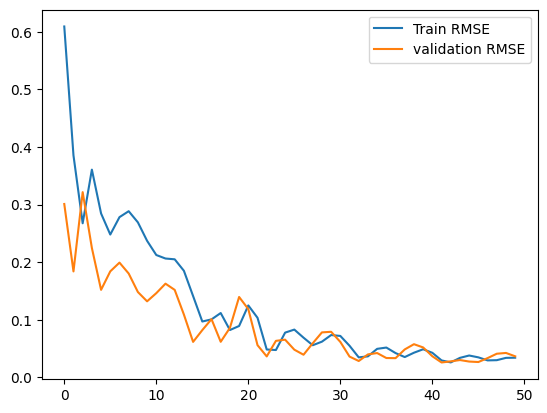

In [247]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

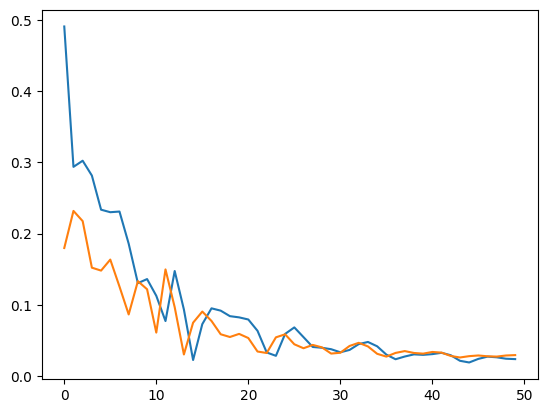

In [235]:
diagnostic_plots(train,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

0.020045595676116603


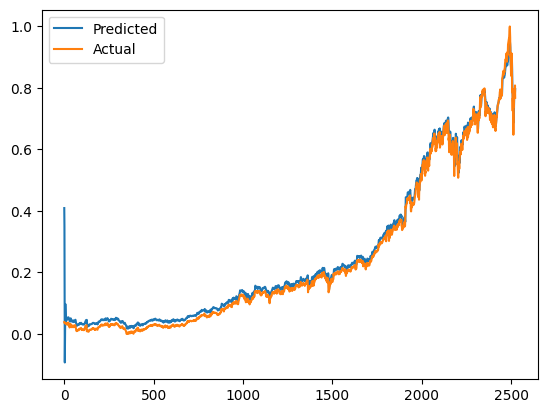

In [236]:
test_model(vanilla_model,X_test,Y_test)

# LSTM RNN

In [250]:
class LSTM_RNN(nn.Module):
    def __init__(self):
        super(LSTM_RNN,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
    
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        c0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        rnn_out,(hn, cn) = self.rnn(X, (h0, c0))
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out
    

In [261]:
model_LSTM=LSTM_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(model_LSTM)

epoch 4, training loss : 0.08050236105918884
epoch 9, training loss : 0.05896160006523132
epoch 14, training loss : 0.007904966361820698
epoch 19, training loss : 0.007478846237063408
epoch 24, training loss : 0.005127303767949343
epoch 29, training loss : 0.0030129938386380672
epoch 34, training loss : 0.0024550168309360743
epoch 39, training loss : 0.0014084065333008766
epoch 44, training loss : 0.0016382692847400904
epoch 49, training loss : 0.0010792206740006804


##### Train and Validation RMSE Plots

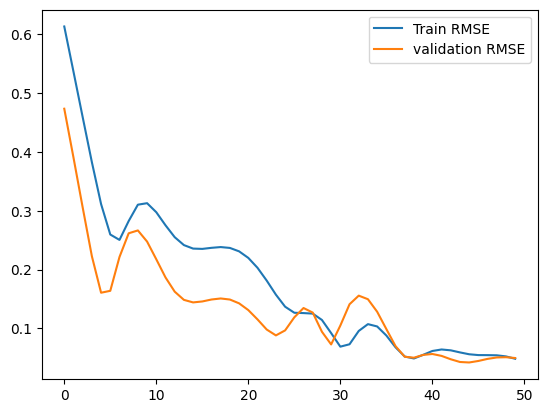

In [252]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Train and Validation Test Loss Plots

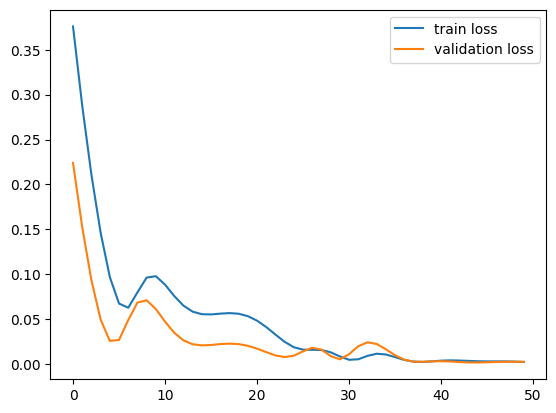

In [254]:
diagnostic_plots(train_loss,"train loss",validation_loss,"validation loss")

#### Model Performance in the Test Data

RMSE:  0.03483957979613603


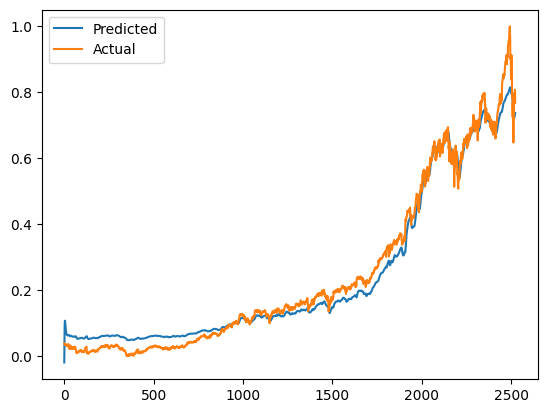

In [256]:
test_model(model_LSTM,X_test,Y_test)

# GRU RNN

In [257]:
class GRU_RNN(nn.Module):
    def __init__(self):
        super(GRU_RNN,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
    
        self.rnn = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        
        rnn_out,(hn, cn) = self.rnn(X, h0)
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out
    

In [258]:
gru_model=GRU_RNN()
train_loss,validation_loss,train_rmse,val_rmse=train(gru_model)

epoch 4, training loss : 0.08791333436965942
epoch 9, training loss : 0.05348304286599159
epoch 14, training loss : 0.017846697941422462
epoch 19, training loss : 0.00705071771517396
epoch 24, training loss : 0.00417756475508213
epoch 29, training loss : 0.0031815494876354933
epoch 34, training loss : 0.0033751046285033226
epoch 39, training loss : 0.0007998805376701057
epoch 44, training loss : 0.0015004564775153995
epoch 49, training loss : 0.0006044768961146474


##### Train and Validation RMSE Plots

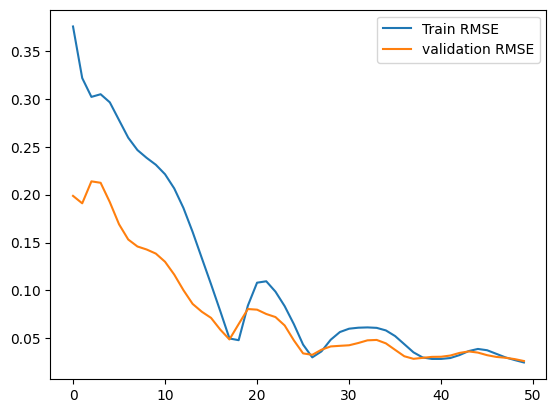

In [260]:
diagnostic_plots(train_rmse,"Train RMSE",val_rmse,"validation RMSE")

#### Model Performance in the Test Data

0.03164014315532615


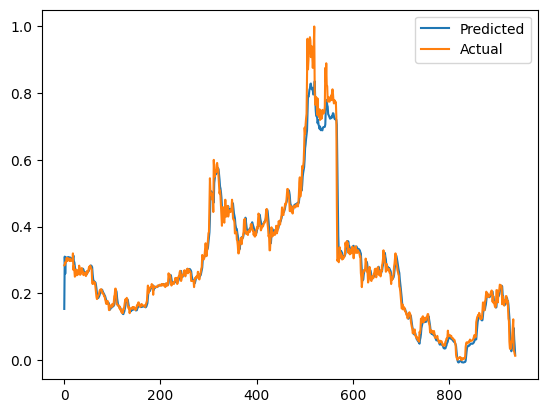

In [218]:
test_model(vanilla_model,X_test,Y_test)

In [219]:
train_data_A=train_data[:80]

In [ ]:
train_x,train_y=genrate_data(train_data_A,20)
X_train=pre_process_data(train_x)
Y_train=pre_process_data(train_y)

In [ ]:
plt.plot(gru_model(X_train).detach().numpy())
plt.plot(Y_train)

In [ ]:
train_data=torch.utils.data.TensorDataset(X_train,Y_train)
val_data=torch.utils.data.TensorDataset(X_val,Y_val)

dataloader_train=torch.utils.data.DataLoader(train_data,batch_size=10,shuffle= False,num_workers=2)
# dataloader_y=torch.utils.data.DataLoader(Y_train,batch_size=10,shuffle= False,num_workers=2)


dataloader_validation=torch.utils.data.DataLoader(val_data,batch_size=10,shuffle= False,num_workers=2)
# dataloader_y=torch.utils.data.DataLoader(Y_train,batch_size=10,shuffle= False,num_workers=2)




In [221]:
class Vanila_RNN_Batch(nn.Module):
    def __init__(self):
        super(Vanila_RNN_Batch,self).__init__()
        self.input_size=1
        self.n_layers=2
        self.hidden_dim=8
        self.output_dim=1
    
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_dim, num_layers = self.n_layers)
        self.fc=nn.Linear(self.hidden_dim,self.output_dim,bias=True)

    def forward(self,X):
        h0=torch.zeros(self.n_layers,X.size(1),self.hidden_dim)
        rnn_out,_status=self.rnn(X,h0)
        #print(rnn_out.shape)
        fc_out=self.fc(rnn_out[:,-1])
        return fc_out

In [222]:
dataloader_train=torch.utils.data.DataLoader(train_data,batch_size=10,shuffle= False,num_workers=2)
# dataloader_y=torch.utils.data.DataLoader(Y_train,batch_size=10,shuffle= False,num_workers=2)


dataloader_validation=torch.utils.data.DataLoader(val_data,batch_size=10,shuffle= False,num_workers=2)
# dataloader_y=torch.utils.data.DataLoader(Y_train,batch_size=10,shuffle= False,num_workers=2)

def train_batch(model):
    
    criterion =  nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # create losses list so that we can append loss of each epoch into the list
    train_loss=[]
    validation_loss=[]
    train_rmse=[]
    val_rmse=[]

   
    for i in range(epochs):
        training_loss=0
        for feature,label in dataloader_train:
        # zero the gradients as we dont want to accumulate it.
                optimizer.zero_grad()
                #calculate yhats/outputs
                outputs = model(feature)
                #calculate loss using mse
                loss = criterion(outputs, label)
                #calculating gradients
                loss.backward()
                #updating the parameters using adam optim
                optimizer.step()
                training_loss+=loss.item()
            
        train_loss.append(loss.item()/10)
        val_output=model(X_val)
        validation_loss.append(criterion(val_output,Y_val).item())

            
        
            #train_loss+=loss.item()
        #append the loss of i th epoch to list of losses
        
        #store train lossel
           
        train_rmse.append(math.sqrt(mean_squared_error(outputs.detach().numpy(),Y_train)))
            # calcualting validation loss
            
            #val_loss=criterion(val_output,Y_val)
        #store validation loss
            #validation_loss.append(val_loss.item())
        val_rmse.append(math.sqrt(mean_squared_error(val_output.detach().numpy(),Y_val)))
        #print losses per 50 epoch
        if (i+1) % 50 == 0:
            print(f'epoch {i}, training loss : {loss.item()}')
    return train_loss,validation_loss,train_rmse,val_rmse



In [223]:
vanilla_model=Vanila_RNN_Batch()
train_loss,validation_loss,train_rmse,val_rmse=train(vanilla_model)

epoch 49, training loss : 0.0009327002335339785
